# Importing Necessary Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, zipfile

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, BatchNormalization, Flatten, MaxPooling2D


# Prepapring Train and Test dataset

In [12]:
train_dir = "/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
test_dir = "/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test"
image_size = (180, 180)
batch_size = 32
class_names = ['Actinic Keratosis', 'Basal Cell Carcinoma', 'Dermatofibroma', 'Melanoma', 'Nevus', 'Pigmented Benign Keratosis', 'Seborrheic Keratosis', 'Squamous Cell Carcinoma', 'Vascular Lesion']


In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels='inferred',
  label_mode='categorical',
  image_size=image_size,
  interpolation='nearest',
  batch_size=batch_size,
  shuffle=True
)

Found 2239 files belonging to 9 classes.


In [4]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  labels='inferred',
  label_mode='categorical',
  image_size=image_size,
  interpolation='nearest',
  batch_size=batch_size,
  shuffle=True
)

Found 118 files belonging to 9 classes.


In [6]:
X_train = []
y_train = []

for images, labels in train_ds:
  X_train.append(images.numpy())
  y_train.append(labels.numpy())

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)


In [7]:
X_test = []
y_test = []

for images, labels in train_ds:
  X_test.append(images.numpy())
  y_test.append(labels.numpy())

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)


In [8]:
y_train.shape

(2239, 9)

In [10]:
y_test.shape

(2239, 9)

In [9]:
X_train.shape

(2239, 180, 180, 3)

In [11]:
X_test.shape

(2239, 180, 180, 3)

# Train dataset visualisation

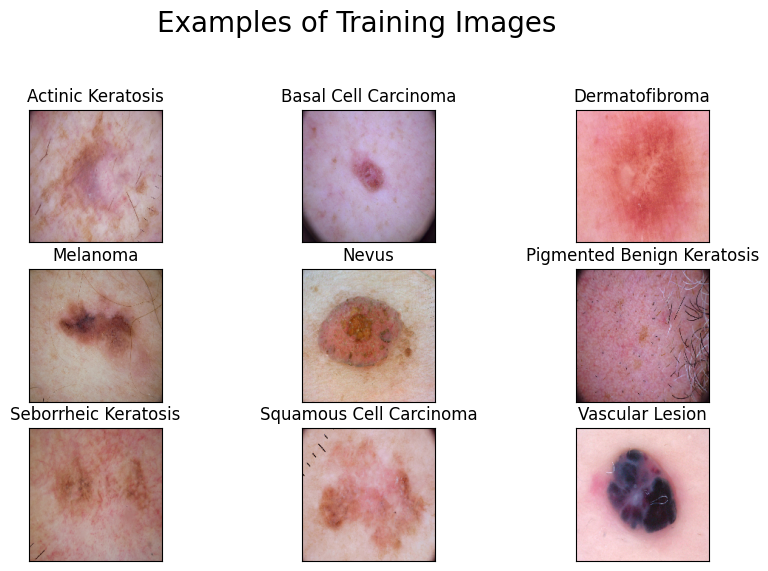

In [19]:
fig = plt.figure(figsize=(10, 10))
for i in range(y_train.shape[1]):
    ax = fig.add_subplot(5, 3, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:, i] == 1)[0]
    features_idx = X_train[idx, ::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num, ::]
    ax.set_title(class_names[i])
    plt.imshow(im.astype('uint8'))
fig.suptitle("Examples of Training Images", fontsize=20)
plt.show()